### Deep learning model training.


In [1]:
import time
import torch
import random
import torch.nn as nn
from glob import glob
from notebooks import config
from utils.imgShow import imsShow
from model import unet, unet_scales 
from utils.utils import read_scenes
from utils.metrics import oa_binary, miou_binary
from utils.dataloader import SceneArraySet_scales, PatchPathSet_scales


In [2]:
patch_size = 256
higher_patch_size = 1024


In [3]:
### traset
paths_scene_tra, paths_truth_tra = config.paths_scene_tra, config.paths_truth_tra
paths_dem_tra = config.paths_dem_tra
# paths_dem_tra = config.paths_dem_adjust_tra
print(f'train scenes: {len(paths_scene_tra)}')
### valset
paths_valset = sorted(glob(f'data/dset/valset/patch_{higher_patch_size}/*'))  ## for model prediction 
# paths_patch_valset = sorted(glob(f'data/dset/valset/patch_{patch_size}_dem_adjust/*'))
print(f'vali patch: {len(paths_valset)}')


train scenes: 48
vali patch: 293


### dataset loading

In [4]:
## load traset
scenes_dem_arr, truths_arr = read_scenes(paths_scene_tra, 
                                            paths_truth_tra, 
                                            paths_dem_tra) 
print('traset:', len(scenes_dem_arr)) 


traset: 48


In [5]:
# Create dataset instances
tra_data = SceneArraySet_scales(scenes_arr=scenes_dem_arr,    
                          truths_arr=truths_arr,   
                          patch_size=256,   
                          higher_patch_size=1024,   
                          patch_resize=True)   
val_data = PatchPathSet_scales(paths_valset=paths_valset,   
                          higher_patch_size=1024,  
                          patch_size=256,  
                          patch_resize=True)     


In [6]:
tra_loader = torch.utils.data.DataLoader(tra_data, 
                                         batch_size=4, 
                                         shuffle=True, 
                                         num_workers=10)
val_loader = torch.utils.data.DataLoader(val_data, 
                                         batch_size=4, 
                                         num_workers=10)


#### Model training

In [7]:
model = unet_scales(num_bands_local=7, 
                    num_bands_global=7, 
                    patch_size=patch_size,
                    higher_patch_size=higher_patch_size)


In [8]:
tra_loader_iter = iter(tra_loader)
val_loader_iter = iter(val_loader)
tra_one = next(tra_loader_iter)
val_one = next(val_loader_iter)
pred_local, pred_global = model(tra_one[0], tra_one[2]) 


In [9]:
### create loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)  
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, \
                                          mode='min', factor=0.6, patience=20)


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha=0.4, gamma=3.0, reduction='mean', eps=1e-8):
        super(BinaryFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.eps = eps

    def forward(self, pred_prob, target_prob):
        pred_prob = torch.clamp(pred_prob, self.eps, 1 - self.eps)        
        bce = - (target_prob * torch.log(pred_prob) + 
                  (1 - target_prob) * torch.log(1 - pred_prob))
        
        pt = torch.where(target_prob == 1, pred_prob, 1 - pred_prob)
        modulating_factor = (1 - pt) ** self.gamma
        alpha_factor = torch.where(target_prob == 1, self.alpha, 1 - self.alpha)
        loss = alpha_factor * modulating_factor * bce
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:  # 'none'
            return loss

loss_focal = BinaryFocalLoss()

In [14]:
class HybridLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, dice_weight=0.5):
        super().__init__()
        self.focal = BinaryFocalLoss(alpha, gamma, reduction='none')
        self.dice_weight = dice_weight
    
    def forward(self, pred, target):
        focal_loss = self.focal(pred, target)
        
        # Dice系数计算
        intersection = (pred * target).sum()
        union = pred.sum() + target.sum()
        dice = 1 - (2. * intersection + 1e-5) / (union + 1e-5)
        
        # 混合损失
        loss = (1 - self.dice_weight) * focal_loss.mean() + self.dice_weight * dice
        return loss

loss_hybrid = HybridLoss(alpha=0.4, gamma=3.0, dice_weight=0.5) 


In [15]:
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=0.25, gamma=2.0):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma

#     def forward(self, inputs, targets):
#         BCE_loss = nn.BCELoss()(inputs, targets)
#         targets = targets.type(torch.float32)
#         pt = torch.exp(-BCE_loss)         
#         F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        
#         return F_loss.mean()
    
# class Loss_scales(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.loss_local = nn.BCELoss() 
#         self.loss_global = nn.BCELoss()
#     def forward(self, x_local, y_local, x_global,  y_global):
#         return self.loss_local(x_local, y_local) + self.loss_global(x_global, y_global)
# loss_scales = Loss_scales()
# loss_focal = FocalLoss()
# loss_bce = nn.BCELoss()     



In [16]:
'''------train step------'''
def train_step(x_patch,
               y_patch,
               x_higher_patch, 
               y_higher_patch,
               model, 
               optimizer, 
               loss_fn):
    optimizer.zero_grad()
    pred_local, pred_global = model(x_patch, x_higher_patch)
    loss = loss_fn(pred_local, y_patch.float())
    # loss = loss_fn(x_local=pred_local, 
    #                 y_local=y_patch.float(), 
    #                 x_global=pred_global, 
    #                 y_global=y_higher_patch.float())
    loss.backward()
    optimizer.step()
    miou = miou_binary(pred=pred_local, truth=y_patch, device=x_patch.device)
    oa = oa_binary(pred=pred_local, truth=y_patch, device=x_patch.device)
    return loss, miou, oa
'''------validation step------'''
def val_step(x_patch,
             y_patch,
             x_higher_patch,
             y_higher_patch, 
             model,
             loss_fn):
    model.eval()
    with torch.no_grad():
        pred_local, pred_global = model(x_patch, x_higher_patch)
        loss = loss_fn(pred_local, y_patch.float())
        # loss = loss_fn(x_local=pred_local, 
        #                y_local=y_patch.float(), 
        #                x_global=pred_global, 
        #                y_global=y_higher_patch.float())
    miou = miou_binary(pred=pred_local, truth=y_patch, device=x_patch.device)
    oa = oa_binary(pred=pred_local, truth=y_patch, device=x_patch.device)
    return loss, miou, oa

'''------train loops------'''
def train_loops(model,
                loss_fn, 
                optimizer, 
                tra_loader, 
                val_loader, 
                epoches, 
                device, 
                lr_scheduler=None):
    tra_loss_loops, tra_miou_loops, tra_oa_loops = [], [], []
    val_loss_loops, val_miou_loops, val_oa_loops = [], [], []
    model = model.to(device)
    size_tra_loader = len(tra_loader)
    size_val_loader = len(val_loader)
    for epoch in range(epoches):
        start = time.time()
        tra_loss, val_loss = 0, 0
        tra_miou, val_miou = 0, 0
        tra_oa, val_oa = 0, 0
        '''-----train the model-----'''
        for x_patch, y_patch, x_higher_patch, y_higher_patch in tra_loader:
            x_patch, y_patch, x_higher_patch, y_higher_patch = x_patch.to(device), y_patch.to(device), x_higher_patch.to(device), y_higher_patch.to(device)
            loss, miou, oa = train_step(x_patch=x_patch, 
                                        y_patch=y_patch,
                                        x_higher_patch=x_higher_patch,
                                        y_higher_patch=y_higher_patch,
                                        model=model,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn)                                        
            tra_loss += loss.item()
            tra_miou += miou.item()
            tra_oa += oa.item()
        if lr_scheduler:
            lr_scheduler.step(tra_loss)    # if using ReduceLROnPlateau
        '''----- validation the model: time consuming -----'''
        for x_patch, y_patch, x_higher_patch, y_higher_patch in val_loader:
            x_patch, y_patch, x_higher_patch, y_higher_patch = x_patch.to(device), y_patch.to(device), x_higher_patch.to(device), y_higher_patch.to(device)
            loss, miou, oa = val_step(x_patch=x_patch, 
                                    y_patch=y_patch, 
                                    x_higher_patch=x_higher_patch, 
                                    y_higher_patch=y_higher_patch, 
                                    model=model, 
                                    loss_fn=loss_fn)            
            val_loss += loss.item()
            val_miou += miou.item()
            val_oa += oa.item()
        ## Accuracy
        tra_loss = tra_loss/size_tra_loader
        val_loss = val_loss/size_val_loader
        tra_miou = tra_miou/size_tra_loader
        val_miou = val_miou/size_val_loader
        tra_oa = tra_oa/size_tra_loader
        val_oa = val_oa/size_val_loader
        tra_loss_loops.append(tra_loss); tra_miou_loops.append(tra_miou); tra_oa_loops.append(tra_oa)
        val_loss_loops.append(val_loss); val_miou_loops.append(val_miou); val_oa_loops.append(val_oa)
        print(f'Ep{epoch+1}: tra-> Loss:{tra_loss:.3f},Oa:{tra_oa:.3f},Miou:{tra_miou:.3f}, '
                f'val-> Loss:{val_loss:.3f},Oa:{val_oa:.3f}, Miou:{val_miou:.3f},time:{time.time()-start:.1f}s')
        ## show the result
        if (epoch+1)%10 == 0:
            model.eval()
            sam_index = random.randrange(len(val_data))
            patch, ptruth, higher_patch, higher_ptruth = val_data[sam_index]
            patch, ptruth = torch.unsqueeze(patch.float(), 0).to(device), ptruth.to(device)
            higher_patch, higher_ptruth = torch.unsqueeze(higher_patch.float(), 0).to(device), torch.unsqueeze(higher_ptruth.float(), 0).to(device)
            pred_local, pred_global = model(patch, higher_patch)
            ## convert to numpy and plot
            patch = patch[0].to('cpu').detach().numpy().transpose(1,2,0)
            pdem = patch[:,:, -1]
            pred_patch = pred_local[0].to('cpu').detach().numpy()
            ptruth = ptruth.to('cpu').detach().numpy()
            pred_higher_patch = pred_global[0].to('cpu').detach().numpy()
            higher_patch = higher_patch[0].to('cpu').detach().numpy().transpose(1,2,0)
            higher_ptruth = higher_ptruth.to('cpu').detach().numpy()
            imsShow([higher_patch, pred_higher_patch, patch, pdem, pred_patch, ptruth], 
                    clip_list = (2,0,2,2,0,0),
                    img_name_list=['input_higher_patch', 'pred_higher_patch', 'input_patch', 
                                   'pdem', 'prediction', 'truth'],                     
                    figsize=(15,3))
    metrics = {'tra_loss':tra_loss_loops, 'tra_miou':tra_miou_loops, 'tra_oa': tra_oa_loops, 
                'val_loss': val_loss_loops, 'val_miou': val_miou_loops, 'val_oa': val_oa_loops}
    return metrics 


Ep1: tra-> Loss:0.073,Oa:0.965,Miou:0.937, val-> Loss:0.166,Oa:0.886, Miou:0.801,time:3.1s
Ep2: tra-> Loss:0.103,Oa:0.915,Miou:0.864, val-> Loss:0.176,Oa:0.876, Miou:0.801,time:2.9s
Ep3: tra-> Loss:0.107,Oa:0.948,Miou:0.873, val-> Loss:0.152,Oa:0.888, Miou:0.807,time:2.8s
Ep4: tra-> Loss:0.059,Oa:0.953,Miou:0.925, val-> Loss:0.158,Oa:0.888, Miou:0.808,time:2.8s
Ep5: tra-> Loss:0.053,Oa:0.955,Miou:0.928, val-> Loss:0.162,Oa:0.889, Miou:0.814,time:2.9s
Ep6: tra-> Loss:0.066,Oa:0.965,Miou:0.915, val-> Loss:0.162,Oa:0.889, Miou:0.816,time:2.9s
Ep7: tra-> Loss:0.040,Oa:0.969,Miou:0.944, val-> Loss:0.161,Oa:0.889, Miou:0.817,time:2.8s
Ep8: tra-> Loss:0.052,Oa:0.949,Miou:0.932, val-> Loss:0.155,Oa:0.891, Miou:0.814,time:2.9s
Ep9: tra-> Loss:0.094,Oa:0.930,Miou:0.888, val-> Loss:0.169,Oa:0.891, Miou:0.813,time:3.1s
Ep10: tra-> Loss:0.091,Oa:0.935,Miou:0.904, val-> Loss:0.168,Oa:0.890, Miou:0.813,time:2.9s


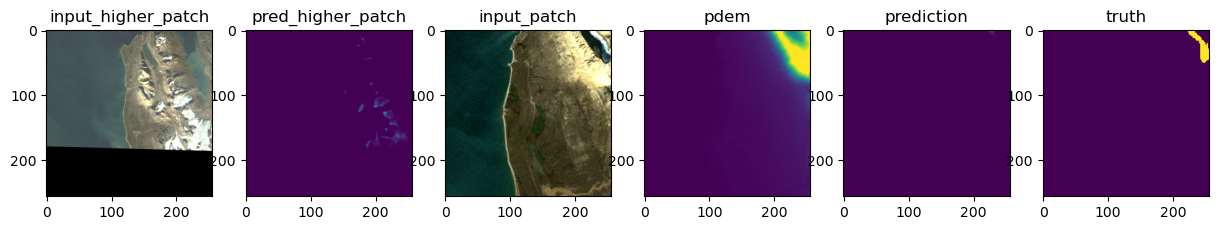

Ep11: tra-> Loss:0.039,Oa:0.976,Miou:0.948, val-> Loss:0.185,Oa:0.888, Miou:0.803,time:3.1s
Ep12: tra-> Loss:0.060,Oa:0.951,Miou:0.919, val-> Loss:0.186,Oa:0.889, Miou:0.800,time:2.8s
Ep13: tra-> Loss:0.042,Oa:0.972,Miou:0.942, val-> Loss:0.181,Oa:0.889, Miou:0.806,time:2.9s
Ep14: tra-> Loss:0.082,Oa:0.933,Miou:0.902, val-> Loss:0.174,Oa:0.890, Miou:0.813,time:3.1s
Ep15: tra-> Loss:0.090,Oa:0.907,Miou:0.886, val-> Loss:0.179,Oa:0.887, Miou:0.812,time:2.8s
Ep16: tra-> Loss:0.041,Oa:0.964,Miou:0.929, val-> Loss:0.168,Oa:0.891, Miou:0.814,time:3.4s
Ep17: tra-> Loss:0.080,Oa:0.967,Miou:0.887, val-> Loss:0.168,Oa:0.889, Miou:0.814,time:2.9s
Ep18: tra-> Loss:0.057,Oa:0.940,Miou:0.912, val-> Loss:0.158,Oa:0.894, Miou:0.819,time:2.9s
Ep19: tra-> Loss:0.060,Oa:0.958,Miou:0.917, val-> Loss:0.159,Oa:0.895, Miou:0.819,time:2.8s
Ep20: tra-> Loss:0.084,Oa:0.932,Miou:0.895, val-> Loss:0.159,Oa:0.899, Miou:0.819,time:3.1s


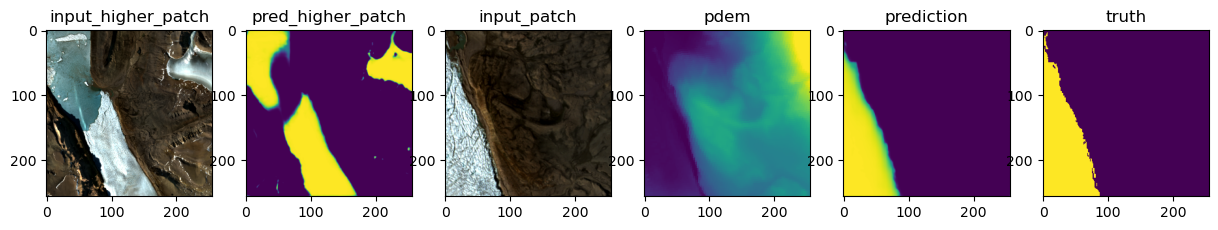

Ep21: tra-> Loss:0.074,Oa:0.930,Miou:0.915, val-> Loss:0.158,Oa:0.901, Miou:0.821,time:3.1s
Ep22: tra-> Loss:0.047,Oa:0.968,Miou:0.936, val-> Loss:0.164,Oa:0.893, Miou:0.819,time:3.0s
Ep23: tra-> Loss:0.061,Oa:0.943,Miou:0.925, val-> Loss:0.166,Oa:0.892, Miou:0.817,time:2.9s
Ep24: tra-> Loss:0.062,Oa:0.954,Miou:0.918, val-> Loss:0.165,Oa:0.892, Miou:0.818,time:2.8s
Ep25: tra-> Loss:0.108,Oa:0.905,Miou:0.872, val-> Loss:0.170,Oa:0.890, Miou:0.813,time:2.8s
Ep26: tra-> Loss:0.037,Oa:0.970,Miou:0.944, val-> Loss:0.166,Oa:0.897, Miou:0.816,time:2.8s
Ep27: tra-> Loss:0.072,Oa:0.959,Miou:0.916, val-> Loss:0.168,Oa:0.892, Miou:0.819,time:3.0s
Ep28: tra-> Loss:0.062,Oa:0.970,Miou:0.922, val-> Loss:0.174,Oa:0.889, Miou:0.819,time:2.9s
Ep29: tra-> Loss:0.043,Oa:0.966,Miou:0.937, val-> Loss:0.170,Oa:0.895, Miou:0.820,time:2.9s
Ep30: tra-> Loss:0.034,Oa:0.970,Miou:0.952, val-> Loss:0.163,Oa:0.898, Miou:0.821,time:2.8s


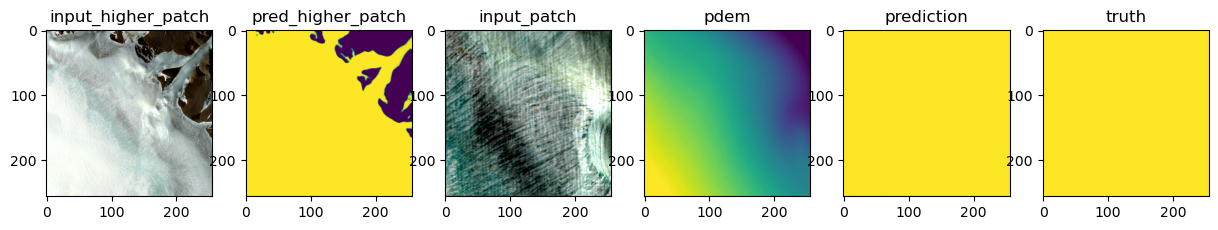

Ep31: tra-> Loss:0.041,Oa:0.969,Miou:0.942, val-> Loss:0.164,Oa:0.892, Miou:0.818,time:2.9s
Ep32: tra-> Loss:0.059,Oa:0.945,Miou:0.924, val-> Loss:0.168,Oa:0.892, Miou:0.815,time:2.8s
Ep33: tra-> Loss:0.076,Oa:0.954,Miou:0.899, val-> Loss:0.167,Oa:0.898, Miou:0.820,time:2.8s
Ep34: tra-> Loss:0.058,Oa:0.957,Miou:0.924, val-> Loss:0.167,Oa:0.898, Miou:0.821,time:3.0s
Ep35: tra-> Loss:0.041,Oa:0.974,Miou:0.943, val-> Loss:0.166,Oa:0.898, Miou:0.821,time:2.9s
Ep36: tra-> Loss:0.047,Oa:0.962,Miou:0.934, val-> Loss:0.168,Oa:0.898, Miou:0.821,time:2.8s
Ep37: tra-> Loss:0.070,Oa:0.935,Miou:0.915, val-> Loss:0.167,Oa:0.893, Miou:0.820,time:2.8s
Ep38: tra-> Loss:0.045,Oa:0.965,Miou:0.939, val-> Loss:0.167,Oa:0.894, Miou:0.818,time:3.1s
Ep39: tra-> Loss:0.076,Oa:0.960,Miou:0.897, val-> Loss:0.171,Oa:0.892, Miou:0.819,time:2.9s
Ep40: tra-> Loss:0.072,Oa:0.932,Miou:0.915, val-> Loss:0.168,Oa:0.893, Miou:0.821,time:2.8s


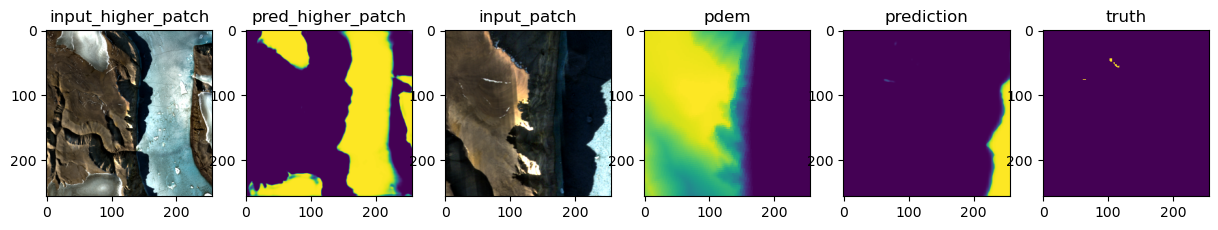

Ep41: tra-> Loss:0.048,Oa:0.958,Miou:0.934, val-> Loss:0.168,Oa:0.894, Miou:0.821,time:3.0s
Ep42: tra-> Loss:0.039,Oa:0.967,Miou:0.943, val-> Loss:0.173,Oa:0.893, Miou:0.820,time:3.2s
Ep43: tra-> Loss:0.033,Oa:0.974,Miou:0.954, val-> Loss:0.175,Oa:0.892, Miou:0.819,time:2.9s
Ep44: tra-> Loss:0.044,Oa:0.960,Miou:0.936, val-> Loss:0.172,Oa:0.895, Miou:0.821,time:2.8s
Ep45: tra-> Loss:0.066,Oa:0.941,Miou:0.919, val-> Loss:0.172,Oa:0.895, Miou:0.821,time:2.8s
Ep46: tra-> Loss:0.046,Oa:0.962,Miou:0.934, val-> Loss:0.174,Oa:0.894, Miou:0.820,time:2.9s
Ep47: tra-> Loss:0.056,Oa:0.956,Miou:0.921, val-> Loss:0.170,Oa:0.895, Miou:0.821,time:2.9s
Ep48: tra-> Loss:0.034,Oa:0.974,Miou:0.948, val-> Loss:0.170,Oa:0.895, Miou:0.822,time:3.1s
Ep49: tra-> Loss:0.033,Oa:0.976,Miou:0.954, val-> Loss:0.171,Oa:0.900, Miou:0.823,time:3.1s
Ep50: tra-> Loss:0.035,Oa:0.977,Miou:0.952, val-> Loss:0.174,Oa:0.899, Miou:0.823,time:3.1s


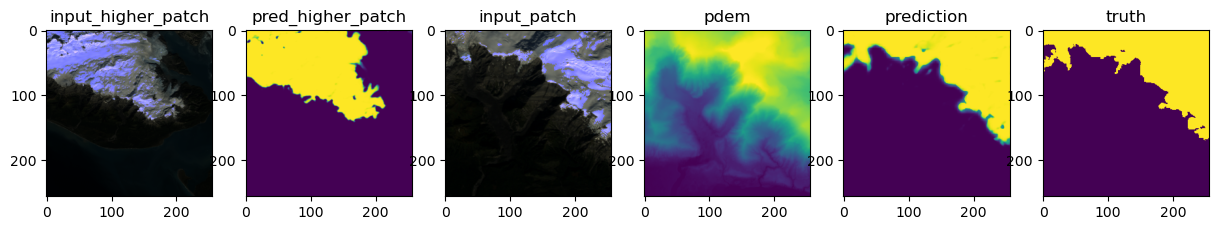

Ep51: tra-> Loss:0.052,Oa:0.967,Miou:0.932, val-> Loss:0.174,Oa:0.900, Miou:0.824,time:2.7s
Ep52: tra-> Loss:0.058,Oa:0.972,Miou:0.933, val-> Loss:0.171,Oa:0.895, Miou:0.825,time:2.9s
Ep53: tra-> Loss:0.045,Oa:0.974,Miou:0.936, val-> Loss:0.172,Oa:0.895, Miou:0.825,time:2.8s
Ep54: tra-> Loss:0.076,Oa:0.963,Miou:0.904, val-> Loss:0.172,Oa:0.898, Miou:0.822,time:2.9s
Ep55: tra-> Loss:0.042,Oa:0.960,Miou:0.939, val-> Loss:0.168,Oa:0.900, Miou:0.823,time:2.9s
Ep56: tra-> Loss:0.045,Oa:0.974,Miou:0.943, val-> Loss:0.164,Oa:0.896, Miou:0.824,time:2.9s
Ep57: tra-> Loss:0.037,Oa:0.974,Miou:0.951, val-> Loss:0.164,Oa:0.896, Miou:0.824,time:2.9s
Ep58: tra-> Loss:0.033,Oa:0.979,Miou:0.957, val-> Loss:0.163,Oa:0.896, Miou:0.823,time:3.0s
Ep59: tra-> Loss:0.058,Oa:0.965,Miou:0.921, val-> Loss:0.164,Oa:0.903, Miou:0.823,time:2.9s
Ep60: tra-> Loss:0.052,Oa:0.957,Miou:0.931, val-> Loss:0.163,Oa:0.903, Miou:0.824,time:2.9s


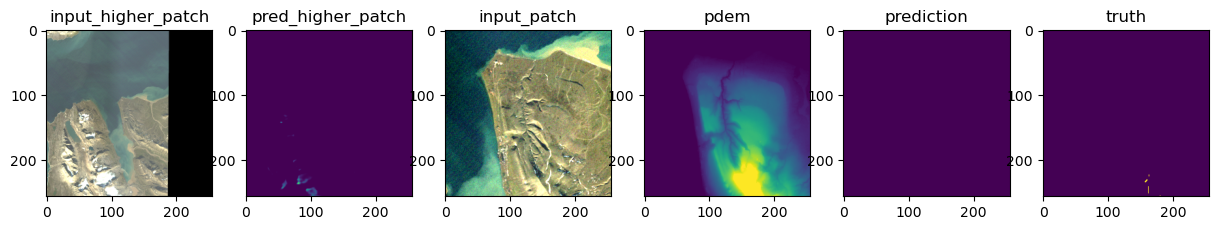

Ep61: tra-> Loss:0.049,Oa:0.970,Miou:0.935, val-> Loss:0.163,Oa:0.897, Miou:0.825,time:2.8s
Ep62: tra-> Loss:0.032,Oa:0.966,Miou:0.952, val-> Loss:0.162,Oa:0.897, Miou:0.825,time:2.8s
Ep63: tra-> Loss:0.037,Oa:0.975,Miou:0.949, val-> Loss:0.163,Oa:0.897, Miou:0.826,time:3.1s
Ep64: tra-> Loss:0.027,Oa:0.983,Miou:0.963, val-> Loss:0.165,Oa:0.903, Miou:0.826,time:2.8s
Ep65: tra-> Loss:0.048,Oa:0.967,Miou:0.932, val-> Loss:0.166,Oa:0.902, Miou:0.826,time:2.7s
Ep66: tra-> Loss:0.047,Oa:0.959,Miou:0.933, val-> Loss:0.164,Oa:0.902, Miou:0.827,time:3.0s
Ep67: tra-> Loss:0.027,Oa:0.979,Miou:0.963, val-> Loss:0.163,Oa:0.903, Miou:0.827,time:2.9s
Ep68: tra-> Loss:0.032,Oa:0.976,Miou:0.954, val-> Loss:0.163,Oa:0.903, Miou:0.827,time:3.1s
Ep69: tra-> Loss:0.053,Oa:0.962,Miou:0.928, val-> Loss:0.163,Oa:0.903, Miou:0.828,time:3.0s
Ep70: tra-> Loss:0.029,Oa:0.981,Miou:0.959, val-> Loss:0.163,Oa:0.903, Miou:0.827,time:3.2s


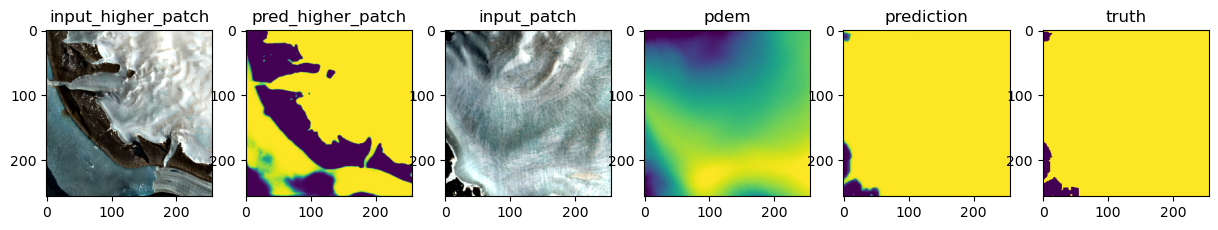

Ep71: tra-> Loss:0.036,Oa:0.970,Miou:0.951, val-> Loss:0.163,Oa:0.903, Miou:0.827,time:3.1s
Ep72: tra-> Loss:0.069,Oa:0.937,Miou:0.918, val-> Loss:0.163,Oa:0.903, Miou:0.826,time:2.8s
Ep73: tra-> Loss:0.037,Oa:0.977,Miou:0.950, val-> Loss:0.164,Oa:0.903, Miou:0.827,time:2.7s
Ep74: tra-> Loss:0.089,Oa:0.928,Miou:0.885, val-> Loss:0.165,Oa:0.903, Miou:0.827,time:2.8s
Ep75: tra-> Loss:0.050,Oa:0.964,Miou:0.932, val-> Loss:0.166,Oa:0.901, Miou:0.827,time:2.8s
Ep76: tra-> Loss:0.030,Oa:0.973,Miou:0.955, val-> Loss:0.166,Oa:0.902, Miou:0.827,time:3.1s
Ep77: tra-> Loss:0.047,Oa:0.962,Miou:0.937, val-> Loss:0.164,Oa:0.902, Miou:0.828,time:3.0s
Ep78: tra-> Loss:0.038,Oa:0.975,Miou:0.952, val-> Loss:0.164,Oa:0.903, Miou:0.828,time:2.8s
Ep79: tra-> Loss:0.040,Oa:0.972,Miou:0.946, val-> Loss:0.164,Oa:0.897, Miou:0.828,time:2.8s
Ep80: tra-> Loss:0.029,Oa:0.977,Miou:0.955, val-> Loss:0.165,Oa:0.903, Miou:0.828,time:2.8s


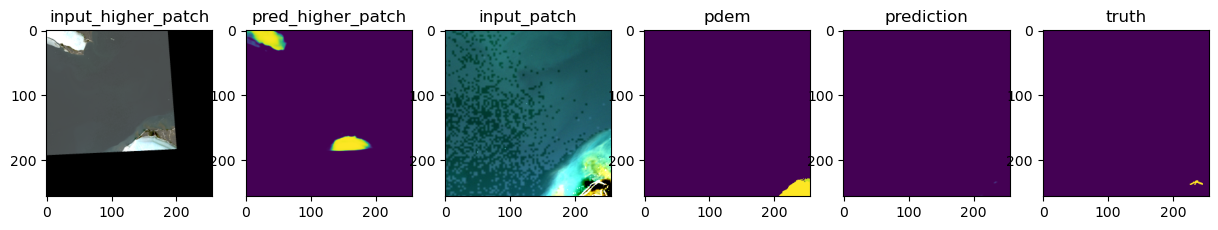

Ep81: tra-> Loss:0.053,Oa:0.960,Miou:0.926, val-> Loss:0.164,Oa:0.903, Miou:0.828,time:2.9s
Ep82: tra-> Loss:0.038,Oa:0.969,Miou:0.950, val-> Loss:0.163,Oa:0.897, Miou:0.828,time:2.8s
Ep83: tra-> Loss:0.035,Oa:0.973,Miou:0.950, val-> Loss:0.162,Oa:0.897, Miou:0.829,time:3.0s
Ep84: tra-> Loss:0.079,Oa:0.927,Miou:0.903, val-> Loss:0.161,Oa:0.898, Miou:0.829,time:2.9s
Ep85: tra-> Loss:0.042,Oa:0.970,Miou:0.942, val-> Loss:0.162,Oa:0.898, Miou:0.828,time:2.9s
Ep86: tra-> Loss:0.096,Oa:0.926,Miou:0.891, val-> Loss:0.161,Oa:0.898, Miou:0.828,time:2.9s
Ep87: tra-> Loss:0.083,Oa:0.939,Miou:0.900, val-> Loss:0.161,Oa:0.904, Miou:0.829,time:2.9s
Ep88: tra-> Loss:0.041,Oa:0.970,Miou:0.946, val-> Loss:0.162,Oa:0.903, Miou:0.829,time:3.3s
Ep89: tra-> Loss:0.036,Oa:0.973,Miou:0.949, val-> Loss:0.162,Oa:0.902, Miou:0.829,time:2.9s
Ep90: tra-> Loss:0.044,Oa:0.966,Miou:0.939, val-> Loss:0.161,Oa:0.903, Miou:0.830,time:3.1s


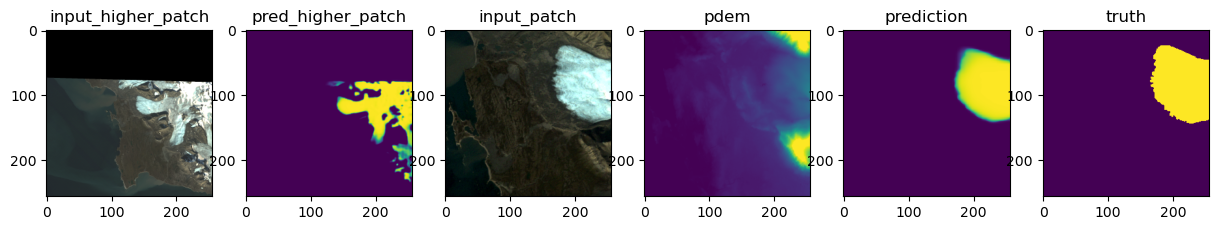

Ep91: tra-> Loss:0.037,Oa:0.975,Miou:0.951, val-> Loss:0.160,Oa:0.904, Miou:0.830,time:2.8s
Ep92: tra-> Loss:0.050,Oa:0.967,Miou:0.938, val-> Loss:0.160,Oa:0.905, Miou:0.829,time:2.9s
Ep93: tra-> Loss:0.059,Oa:0.949,Miou:0.926, val-> Loss:0.162,Oa:0.904, Miou:0.829,time:2.9s
Ep94: tra-> Loss:0.075,Oa:0.937,Miou:0.914, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.1s
Ep95: tra-> Loss:0.050,Oa:0.954,Miou:0.934, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:2.9s
Ep96: tra-> Loss:0.027,Oa:0.982,Miou:0.960, val-> Loss:0.164,Oa:0.904, Miou:0.830,time:3.0s
Ep97: tra-> Loss:0.048,Oa:0.968,Miou:0.935, val-> Loss:0.164,Oa:0.904, Miou:0.830,time:2.8s
Ep98: tra-> Loss:0.036,Oa:0.971,Miou:0.949, val-> Loss:0.164,Oa:0.904, Miou:0.830,time:2.8s
Ep99: tra-> Loss:0.102,Oa:0.901,Miou:0.878, val-> Loss:0.164,Oa:0.904, Miou:0.830,time:2.9s
Ep100: tra-> Loss:0.040,Oa:0.969,Miou:0.945, val-> Loss:0.164,Oa:0.904, Miou:0.830,time:3.1s


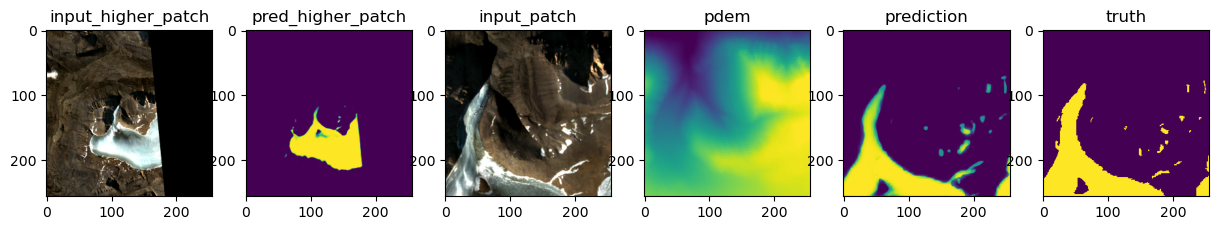

Ep101: tra-> Loss:0.055,Oa:0.972,Miou:0.923, val-> Loss:0.163,Oa:0.904, Miou:0.829,time:2.9s
Ep102: tra-> Loss:0.040,Oa:0.973,Miou:0.946, val-> Loss:0.163,Oa:0.903, Miou:0.830,time:2.9s
Ep103: tra-> Loss:0.041,Oa:0.965,Miou:0.943, val-> Loss:0.163,Oa:0.903, Miou:0.830,time:2.8s
Ep104: tra-> Loss:0.042,Oa:0.963,Miou:0.942, val-> Loss:0.163,Oa:0.904, Miou:0.830,time:2.9s
Ep105: tra-> Loss:0.049,Oa:0.969,Miou:0.939, val-> Loss:0.163,Oa:0.904, Miou:0.830,time:2.7s
Ep106: tra-> Loss:0.034,Oa:0.968,Miou:0.951, val-> Loss:0.163,Oa:0.904, Miou:0.830,time:3.1s
Ep107: tra-> Loss:0.080,Oa:0.933,Miou:0.905, val-> Loss:0.163,Oa:0.904, Miou:0.830,time:3.2s
Ep108: tra-> Loss:0.067,Oa:0.961,Miou:0.916, val-> Loss:0.163,Oa:0.903, Miou:0.830,time:2.9s
Ep109: tra-> Loss:0.076,Oa:0.927,Miou:0.910, val-> Loss:0.162,Oa:0.904, Miou:0.830,time:3.0s
Ep110: tra-> Loss:0.036,Oa:0.974,Miou:0.951, val-> Loss:0.162,Oa:0.904, Miou:0.830,time:2.9s


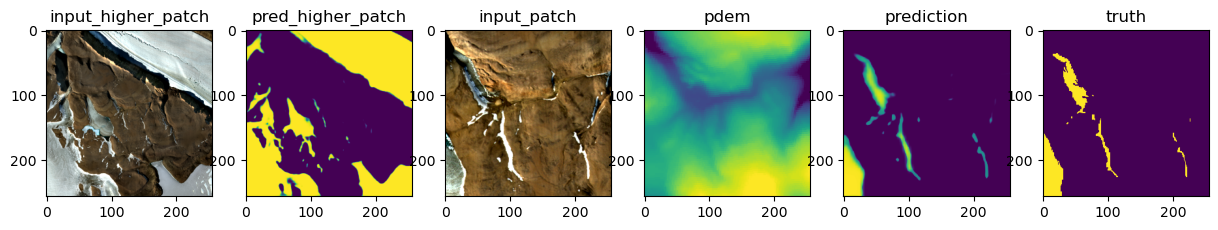

Ep111: tra-> Loss:0.042,Oa:0.973,Miou:0.944, val-> Loss:0.162,Oa:0.904, Miou:0.830,time:2.9s
Ep112: tra-> Loss:0.030,Oa:0.980,Miou:0.959, val-> Loss:0.163,Oa:0.904, Miou:0.830,time:2.9s
Ep113: tra-> Loss:0.028,Oa:0.979,Miou:0.960, val-> Loss:0.163,Oa:0.904, Miou:0.830,time:3.1s
Ep114: tra-> Loss:0.052,Oa:0.959,Miou:0.931, val-> Loss:0.163,Oa:0.904, Miou:0.830,time:3.1s
Ep115: tra-> Loss:0.077,Oa:0.934,Miou:0.909, val-> Loss:0.163,Oa:0.904, Miou:0.830,time:3.5s
Ep116: tra-> Loss:0.036,Oa:0.968,Miou:0.951, val-> Loss:0.163,Oa:0.904, Miou:0.830,time:2.9s
Ep117: tra-> Loss:0.051,Oa:0.953,Miou:0.929, val-> Loss:0.162,Oa:0.904, Miou:0.830,time:2.8s
Ep118: tra-> Loss:0.085,Oa:0.931,Miou:0.892, val-> Loss:0.162,Oa:0.905, Miou:0.830,time:2.9s
Ep119: tra-> Loss:0.029,Oa:0.981,Miou:0.962, val-> Loss:0.162,Oa:0.905, Miou:0.830,time:3.3s
Ep120: tra-> Loss:0.053,Oa:0.964,Miou:0.933, val-> Loss:0.162,Oa:0.905, Miou:0.830,time:3.1s


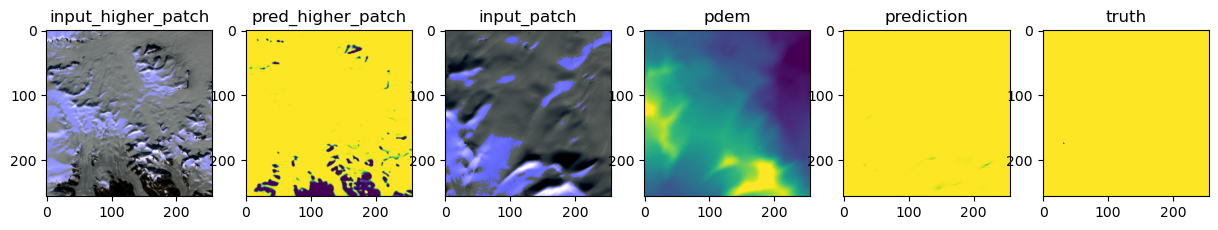

Ep121: tra-> Loss:0.039,Oa:0.976,Miou:0.947, val-> Loss:0.161,Oa:0.905, Miou:0.830,time:2.9s
Ep122: tra-> Loss:0.046,Oa:0.979,Miou:0.938, val-> Loss:0.161,Oa:0.905, Miou:0.830,time:3.0s
Ep123: tra-> Loss:0.054,Oa:0.968,Miou:0.933, val-> Loss:0.161,Oa:0.904, Miou:0.830,time:3.1s
Ep124: tra-> Loss:0.037,Oa:0.974,Miou:0.946, val-> Loss:0.161,Oa:0.904, Miou:0.830,time:3.1s
Ep125: tra-> Loss:0.042,Oa:0.971,Miou:0.938, val-> Loss:0.161,Oa:0.905, Miou:0.830,time:2.9s
Ep126: tra-> Loss:0.031,Oa:0.973,Miou:0.957, val-> Loss:0.161,Oa:0.905, Miou:0.831,time:2.9s
Ep127: tra-> Loss:0.031,Oa:0.979,Miou:0.955, val-> Loss:0.161,Oa:0.905, Miou:0.831,time:3.4s
Ep128: tra-> Loss:0.037,Oa:0.972,Miou:0.949, val-> Loss:0.161,Oa:0.905, Miou:0.831,time:3.1s
Ep129: tra-> Loss:0.029,Oa:0.979,Miou:0.961, val-> Loss:0.162,Oa:0.905, Miou:0.831,time:3.5s
Ep130: tra-> Loss:0.039,Oa:0.970,Miou:0.949, val-> Loss:0.162,Oa:0.905, Miou:0.831,time:3.1s


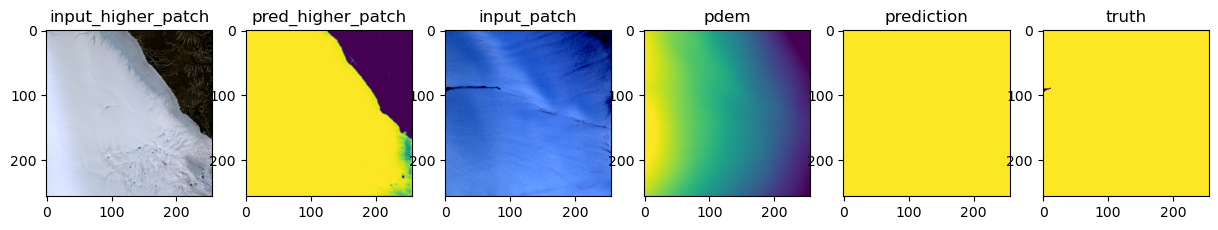

Ep131: tra-> Loss:0.061,Oa:0.957,Miou:0.914, val-> Loss:0.161,Oa:0.905, Miou:0.831,time:3.2s
Ep132: tra-> Loss:0.068,Oa:0.952,Miou:0.923, val-> Loss:0.161,Oa:0.905, Miou:0.831,time:3.2s
Ep133: tra-> Loss:0.069,Oa:0.934,Miou:0.912, val-> Loss:0.161,Oa:0.905, Miou:0.831,time:3.6s
Ep134: tra-> Loss:0.033,Oa:0.981,Miou:0.956, val-> Loss:0.161,Oa:0.905, Miou:0.831,time:3.8s
Ep135: tra-> Loss:0.034,Oa:0.972,Miou:0.951, val-> Loss:0.162,Oa:0.904, Miou:0.830,time:3.8s
Ep136: tra-> Loss:0.071,Oa:0.940,Miou:0.919, val-> Loss:0.163,Oa:0.904, Miou:0.830,time:3.4s
Ep137: tra-> Loss:0.039,Oa:0.971,Miou:0.944, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.9s
Ep138: tra-> Loss:0.046,Oa:0.961,Miou:0.937, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.4s
Ep139: tra-> Loss:0.034,Oa:0.974,Miou:0.953, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.5s
Ep140: tra-> Loss:0.061,Oa:0.969,Miou:0.917, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.7s


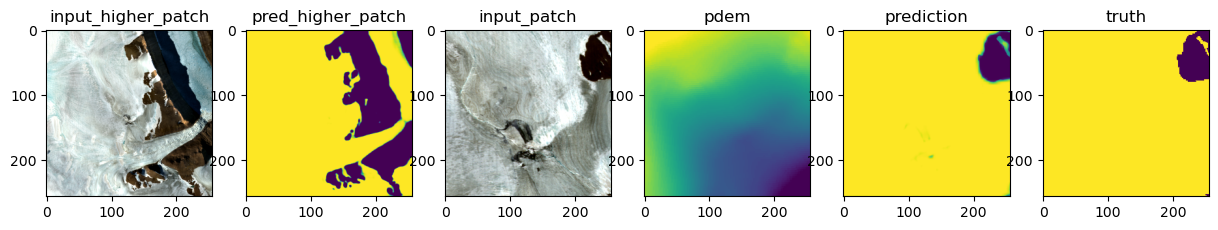

Ep141: tra-> Loss:0.080,Oa:0.951,Miou:0.898, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.7s
Ep142: tra-> Loss:0.046,Oa:0.971,Miou:0.939, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.9s
Ep143: tra-> Loss:0.046,Oa:0.956,Miou:0.938, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.7s
Ep144: tra-> Loss:0.035,Oa:0.974,Miou:0.954, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.6s
Ep145: tra-> Loss:0.105,Oa:0.903,Miou:0.877, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.7s
Ep146: tra-> Loss:0.057,Oa:0.968,Miou:0.922, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.8s
Ep147: tra-> Loss:0.062,Oa:0.969,Miou:0.916, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.7s
Ep148: tra-> Loss:0.060,Oa:0.969,Miou:0.918, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.7s
Ep149: tra-> Loss:0.045,Oa:0.967,Miou:0.940, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.6s
Ep150: tra-> Loss:0.043,Oa:0.972,Miou:0.940, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.6s


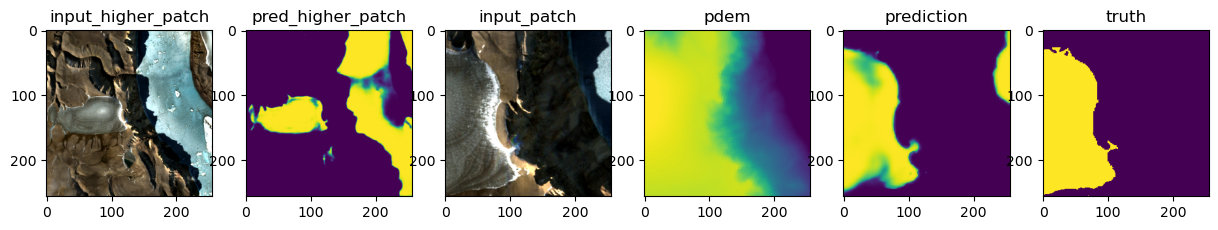

Ep151: tra-> Loss:0.031,Oa:0.975,Miou:0.958, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.3s
Ep152: tra-> Loss:0.027,Oa:0.980,Miou:0.962, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.7s
Ep153: tra-> Loss:0.048,Oa:0.963,Miou:0.936, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.5s
Ep154: tra-> Loss:0.071,Oa:0.926,Miou:0.907, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.8s
Ep155: tra-> Loss:0.037,Oa:0.970,Miou:0.948, val-> Loss:0.163,Oa:0.903, Miou:0.830,time:3.6s
Ep156: tra-> Loss:0.027,Oa:0.980,Miou:0.961, val-> Loss:0.163,Oa:0.903, Miou:0.830,time:3.5s
Ep157: tra-> Loss:0.043,Oa:0.972,Miou:0.942, val-> Loss:0.163,Oa:0.903, Miou:0.830,time:3.3s
Ep158: tra-> Loss:0.099,Oa:0.927,Miou:0.879, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.7s
Ep159: tra-> Loss:0.042,Oa:0.968,Miou:0.944, val-> Loss:0.163,Oa:0.903, Miou:0.830,time:3.5s
Ep160: tra-> Loss:0.052,Oa:0.953,Miou:0.932, val-> Loss:0.163,Oa:0.903, Miou:0.830,time:3.3s


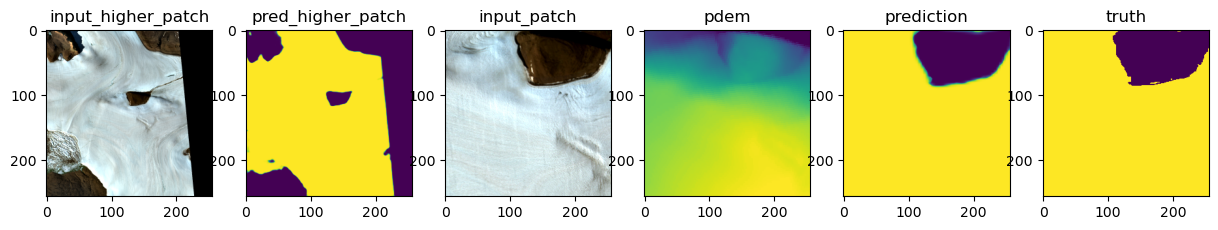

Ep161: tra-> Loss:0.034,Oa:0.975,Miou:0.951, val-> Loss:0.163,Oa:0.903, Miou:0.830,time:3.4s
Ep162: tra-> Loss:0.051,Oa:0.962,Miou:0.929, val-> Loss:0.163,Oa:0.903, Miou:0.830,time:3.6s
Ep163: tra-> Loss:0.032,Oa:0.979,Miou:0.954, val-> Loss:0.163,Oa:0.903, Miou:0.830,time:3.2s
Ep164: tra-> Loss:0.099,Oa:0.896,Miou:0.880, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.3s
Ep165: tra-> Loss:0.048,Oa:0.965,Miou:0.934, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.7s
Ep166: tra-> Loss:0.078,Oa:0.929,Miou:0.908, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.5s
Ep167: tra-> Loss:0.031,Oa:0.978,Miou:0.957, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.5s
Ep168: tra-> Loss:0.060,Oa:0.966,Miou:0.920, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.4s
Ep169: tra-> Loss:0.094,Oa:0.943,Miou:0.883, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.4s
Ep170: tra-> Loss:0.036,Oa:0.972,Miou:0.952, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.9s


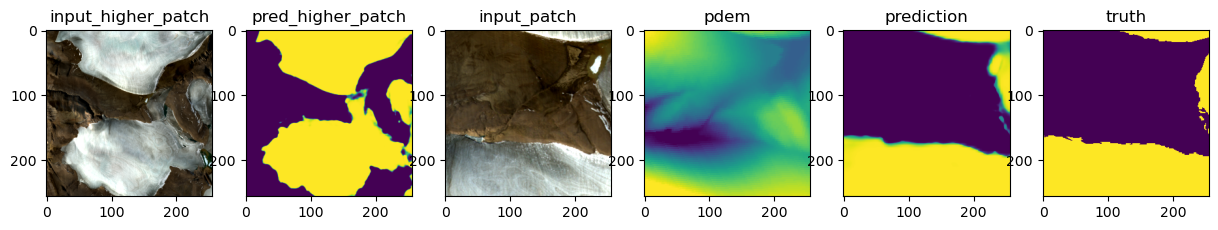

Ep171: tra-> Loss:0.053,Oa:0.976,Miou:0.923, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.6s
Ep172: tra-> Loss:0.038,Oa:0.971,Miou:0.949, val-> Loss:0.164,Oa:0.902, Miou:0.830,time:3.2s
Ep173: tra-> Loss:0.055,Oa:0.977,Miou:0.942, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.4s
Ep174: tra-> Loss:0.048,Oa:0.968,Miou:0.936, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.4s
Ep175: tra-> Loss:0.035,Oa:0.977,Miou:0.955, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.4s
Ep176: tra-> Loss:0.041,Oa:0.970,Miou:0.944, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.5s
Ep177: tra-> Loss:0.032,Oa:0.977,Miou:0.957, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.6s
Ep178: tra-> Loss:0.028,Oa:0.981,Miou:0.962, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.8s
Ep179: tra-> Loss:0.039,Oa:0.968,Miou:0.946, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.4s
Ep180: tra-> Loss:0.074,Oa:0.941,Miou:0.908, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.5s


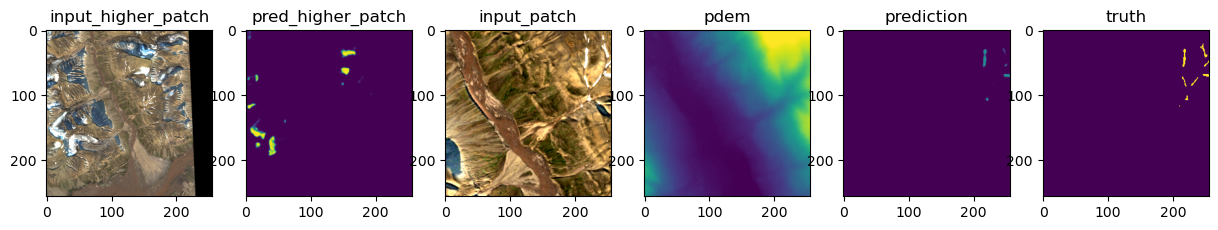

Ep181: tra-> Loss:0.034,Oa:0.970,Miou:0.951, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:4.2s
Ep182: tra-> Loss:0.078,Oa:0.928,Miou:0.907, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.7s
Ep183: tra-> Loss:0.046,Oa:0.956,Miou:0.936, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.4s
Ep184: tra-> Loss:0.041,Oa:0.973,Miou:0.945, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.4s
Ep185: tra-> Loss:0.028,Oa:0.981,Miou:0.962, val-> Loss:0.164,Oa:0.903, Miou:0.830,time:3.5s


In [ ]:
device = torch.device('cuda:0')  
metrics = train_loops(model=model,  
                      epoches=200,  
                      loss_fn=loss_hybrid,  
                      optimizer=optimizer,  
                      lr_scheduler=lr_scheduler,   
                      tra_loader=tra_loader,    
                      val_loader=val_loader,  
                      device=device)  


In [ ]:
### model saving
# model_name = 'u2net'
### net_name = 'deeplabv3plus'
### net_name = 'deeplabv3plus_mb2'
# path_save = f'model/trained/{model_name}_{patch_size}/{model_name}.pth'
# torch.save(model.state_dict(), path_save)   ## save weights of the trained model 
# # # model.load_state_dict(torch.load(path_save, weights_only=True))  # load the weights of the trained model
# # # ## metrics saving
# path_metrics = f'model/trained/{model_name}_{patch_size}/{model_name}_metrics.csv'
# metrics_df = pd.DataFrame(metrics)
# metrics_df.to_csv(path_metrics, index=False, sep=',')

